# Вспомогательный код

Чтобы результаты экспериментов воспроизводились, зафиксируем seed's:

In [1]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

Для выполнения задания рекомендуется использовать среду с аппаратным ускорителем GPU:

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Установим необходимые библиотеки:

In [3]:
from IPython.display import clear_output

!pip install -q -U transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets evaluate
!pip install -q trl bitsandbytes peft

clear_output()

# Задание 1. "Естественность" языка

Важная задача в NLP — оценка качества сгенерированного текста.
Одной из популярных метрик является [перплексия ✏️[blog]](https://habr.com/ru/companies/wunderfund/articles/580230/), в основе которой вероятность существования предложения в критериях выбранной обученной модели.

Сейчас появляются метрики, которые не просто применяются "для нейросетей", они сами являются нейросетями. [RuCoLa ✏️[blog]](https://habr.com/ru/articles/667336/) — одна из характерных представителей. Крупный проект, со своим API и [лидербордом 🛠️[doc]](https://rucola-benchmark.com/leaderboard).

Подобные рейтинги, кстати, используются для выбора лучших моделей под наши задачи.

RuCoLa, обученная на предложениях, тщательно отобранных вручную лингвистами, производит бинарную классификацию (*приемлемо* или *неприемлемо*), а также выдаёт оценку "уверенности" в своём ответе (вероятность класса).

**Задачи**:

* Возьмите два предложенных текста по 12 предложений, получите для каждого предложения значения метрик "**RuCoLa**" и "**перплексия**".
* Аугментируйте предложения с помощью библиотек для аугментации текстов, посчитайте метрики.
* Постройте "ящики с усами" полученных значений метрик до и после аугментации.

Установка и импорт необходимых библиотек:

In [26]:
!pip install -q nlpaug

In [27]:
import torch
import numpy as np
import transformers
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import AutoModelForMaskedLM, AutoTokenizer
from IPython.display import clear_output

Посмотрим, как получить метрику RuCoLa. `LABEL_1` означает, что предложение пригодное, `LABEL_0` — непригодное, `score` — степень уверенности модели в промежутке от 0 до 1 (вероятность).

    
> Это специально обученная модель для рассчёта метрики, применение к другим типам задач может привести к произвольным результатам.

In [28]:
from transformers import pipeline

classifier = pipeline("text-classification", model="RussianNLP/ruRoBERTa-large-rucola")
clear_output()

Оценим предложения, сгенерированные нейросетью.

In [30]:
text_gen = [
    "Однажды вечером я решил приготовить борщ.",
    "Я купил все необходимое ингредиенты и начал готовить.",
    "Через несколько часов борщ готовился, и я решил приготовить блины и пельмени.",
    "Я начал приготавливать блины, используя те же ингредиенты, что и для борща.",
    "Я добавил муку, яйца, молоко, соль и перец, и смешал все вместе.",
    "Затем я выложил тесто в форму и выпекал блины.",
    "После того, как блины готовы, я начал приготавливать пельмени.",
    "Я добавил муку, яйца, молоко и соль, и смешал все вместе.",
    "Затем я выложил тесто в формы и выпекал пельмени.",
    "Когда борщ, блины и пельмени готовы, я подал все вместе на стол.",
    "Мы наслаждались вкусным борщем, блинами и пельменами.",
    "Это было настоящее удовольствие!",
]

In [31]:
gen = classifier(text_gen)

In [32]:
for text,elem in zip(text_gen,gen):
  print(f"label - {elem['label']}, score - {elem['score']:.3f} text - {text}")

label - LABEL_1, score - 0.996 text - Однажды вечером я решил приготовить борщ.
label - LABEL_0, score - 0.960 text - Я купил все необходимое ингредиенты и начал готовить.
label - LABEL_0, score - 0.913 text - Через несколько часов борщ готовился, и я решил приготовить блины и пельмени.
label - LABEL_1, score - 0.984 text - Я начал приготавливать блины, используя те же ингредиенты, что и для борща.
label - LABEL_1, score - 0.984 text - Я добавил муку, яйца, молоко, соль и перец, и смешал все вместе.
label - LABEL_0, score - 0.725 text - Затем я выложил тесто в форму и выпекал блины.
label - LABEL_0, score - 0.995 text - После того, как блины готовы, я начал приготавливать пельмени.
label - LABEL_1, score - 0.986 text - Я добавил муку, яйца, молоко и соль, и смешал все вместе.
label - LABEL_0, score - 0.824 text - Затем я выложил тесто в формы и выпекал пельмени.
label - LABEL_0, score - 0.986 text - Когда борщ, блины и пельмени готовы, я подал все вместе на стол.
label - LABEL_1, score

Обратите внимание на разделение по классам. Вы, скорее всего, не являетесь профессиональным лингвистом, но, возможно, сможете оценить (не)естественность предложений.

Ниже представлены предложения из учебника "Русский язык для иностранцев".

In [33]:
text_real = [
    "Привет, любимая.",
    "Как дела?",
    "Что делаешь?",
    "Я сейчас в метро, еду на урок русского языка.",
    "Обычно я езжу на урок на метро.",
    "Метро - очень популярный вид транспорта в Москве, потому что в городе всегда пробки.",
    "Ты знаешь, что значит слово «пробка»?",
    "По-русски «пробка» - это когда на улице все машины стоят и не едут.",
    "А ещё пробка есть в бутылке.",
    "В метро всегда много народу и очень шумно.",
    "Но оно очень красивое, как музей.",
    "И ещё оно быстрое и удобное.",
]

In [34]:
real = classifier(text_real)

In [35]:
for text,elem in zip(text_real,real):
  print(f"label - {elem['label']}, score - {elem['score']:.3f} text - {text}")

label - LABEL_1, score - 0.991 text - Привет, любимая.
label - LABEL_1, score - 0.997 text - Как дела?
label - LABEL_1, score - 0.996 text - Что делаешь?
label - LABEL_1, score - 0.994 text - Я сейчас в метро, еду на урок русского языка.
label - LABEL_1, score - 0.997 text - Обычно я езжу на урок на метро.
label - LABEL_0, score - 0.919 text - Метро - очень популярный вид транспорта в Москве, потому что в городе всегда пробки.
label - LABEL_1, score - 0.998 text - Ты знаешь, что значит слово «пробка»?
label - LABEL_1, score - 0.993 text - По-русски «пробка» - это когда на улице все машины стоят и не едут.
label - LABEL_1, score - 0.976 text - А ещё пробка есть в бутылке.
label - LABEL_1, score - 0.994 text - В метро всегда много народу и очень шумно.
label - LABEL_1, score - 0.994 text - Но оно очень красивое, как музей.
label - LABEL_1, score - 0.994 text - И ещё оно быстрое и удобное.


Воспользуемся метрикой [перплексия ✏️[blog]](https://habr.com/ru/companies/wunderfund/articles/580230/). Чем значение больше, тем хуже.

In [38]:
from transformers import AutoModelForMaskedLM, AutoTokenizer


model_name = "cointegrated/rubert-tiny2"
model = AutoModelForMaskedLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


def score(model, tokenizer, sentence):
    tensor_input = tokenizer.encode(sentence, return_tensors="pt")
    repeat_input = tensor_input.repeat(tensor_input.size(-1) - 2, 1)
    mask = torch.ones(tensor_input.size(-1) - 1).diag(1)[:-2]
    masked_input = repeat_input.masked_fill(mask == 1, tokenizer.mask_token_id)
    labels = repeat_input.masked_fill(masked_input != tokenizer.mask_token_id, -100)
    with torch.inference_mode():
        loss = model(masked_input, labels=labels).loss
    return np.exp(loss.item())


clear_output()

print(
    score(
        sentence="Лондон - столица Великобритании.",
        model=model,
        tokenizer=tokenizer,
    )
)
print(
    score(
        sentence="Лондон - столица Ваканды",
        model=model,
        tokenizer=tokenizer,
    )
)

32.090743041809375
2123.0120242496596


Посчитайте перплексию для предложений в `text_gen` и `text_real` (для каждого предложения отдельно, лучше в формате двух списков (`list`)).

In [39]:
perplex_text_gen =[score(model, tokenizer, sentence) for sentence in text_gen]
perplex_text_real = [score(model, tokenizer, sentence) for sentence in text_real]

Возьмём библиотеку аугментации текстов `nlpaug` из прошлой лекции и попортим оба текста. Посчитайте по ним перплексию, RuCoLa.

Настройки аугментации можете изменить на свой вкус.

In [40]:
import nlpaug.augmenter.word as naw


augment = naw.ContextualWordEmbsAug(
    model_path="cointegrated/rubert-tiny2", action="substitute", aug_p=0.2
)
augmented_text_gen = augment.augment(text_gen)

augmented_text_gen

['Чем вечером я решил приготовить картошку.',
 'Новый купил все необходимое ингредиенты уже начал готовить.',
 'Через несколько раз уже закончился, и я решил приготовить блины от пельмени.',
 'Я могу приготавливать блины, используя те же ингредиенты, витамины и от них.',
 'Он добавил муку, яйца, молоко, соль зеленый перец, и добавьте все фрукты.',
 'Затем он выложил фото в форму и выпекал хлеб.',
 'Срок лечения, как блины нет, я начал приготавливать блюдо.',
 'Я добавил муку, сок, молоко и молочные, и перец все специи.',
 'Затем я выложил тесто из формы жизни несколько пельмени.',
 'За борщ, ели и пельмени дни, её подал все вместе на стол.',
 'Мы часто не борщем, блинами над пельменами.',
 'Это было получать удовольствие!']

Посчитайте метрики. Они могут как улучшиться, так и ухудшиться.

In [41]:
gen_aug = classifier(augmented_text_gen)
gen_aug

[{'label': 'LABEL_0', 'score': 0.9913221597671509},
 {'label': 'LABEL_0', 'score': 0.9472000002861023},
 {'label': 'LABEL_0', 'score': 0.9953123331069946},
 {'label': 'LABEL_0', 'score': 0.9932670593261719},
 {'label': 'LABEL_0', 'score': 0.9852573275566101},
 {'label': 'LABEL_0', 'score': 0.9185508489608765},
 {'label': 'LABEL_0', 'score': 0.9955174326896667},
 {'label': 'LABEL_0', 'score': 0.9794832468032837},
 {'label': 'LABEL_0', 'score': 0.9910613894462585},
 {'label': 'LABEL_0', 'score': 0.9965479969978333},
 {'label': 'LABEL_0', 'score': 0.9895400404930115},
 {'label': 'LABEL_0', 'score': 0.9966868758201599}]

Сделайте аугментацию второго текста.

In [42]:
augmented_real_text = augment.augment(text_real)
real_aug = classifier(augmented_real_text)
real_aug

[{'label': 'LABEL_1', 'score': 0.8656539916992188},
 {'label': 'LABEL_0', 'score': 0.9827577471733093},
 {'label': 'LABEL_0', 'score': 0.9514452219009399},
 {'label': 'LABEL_0', 'score': 0.8123587369918823},
 {'label': 'LABEL_0', 'score': 0.9871630072593689},
 {'label': 'LABEL_0', 'score': 0.9968390464782715},
 {'label': 'LABEL_0', 'score': 0.9838303923606873},
 {'label': 'LABEL_0', 'score': 0.9520015120506287},
 {'label': 'LABEL_0', 'score': 0.9860844016075134},
 {'label': 'LABEL_0', 'score': 0.9898982048034668},
 {'label': 'LABEL_1', 'score': 0.9852038621902466},
 {'label': 'LABEL_0', 'score': 0.994317352771759}]

Посчитайте метрики.

In [45]:
perplex_text_gen_aug = [score(model, tokenizer, sentence) for sentence in augmented_text_gen]
perplex_text_real_aug = [score(model, tokenizer, sentence) for sentence in augmented_real_text]

gen_aug_scores = classifier(augmented_text_gen)
real_aug_scores = classifier(augmented_real_text)

Постройте ящики с усами по обоим метрикам. Для это постройте два subplot'a, на каждом из них выведите по 4 ящика. На левом subplot'е — RuCoLa, на правом — перплексия.

В массивы ниже достаточно записать наборы чисел в формате `list`, дальше код построит по ним "ящики с усами".

In [46]:
real_scores = [item['score'] for item in real_scores]
gen_scores = [item['score'] for item in gen_scores]
real_aug_scores = [item['score'] for item in real_aug_scores]
gen_aug_scores =  [item['score'] for item in gen_aug_scores]

Ниже представлен код для удобства визуализации.

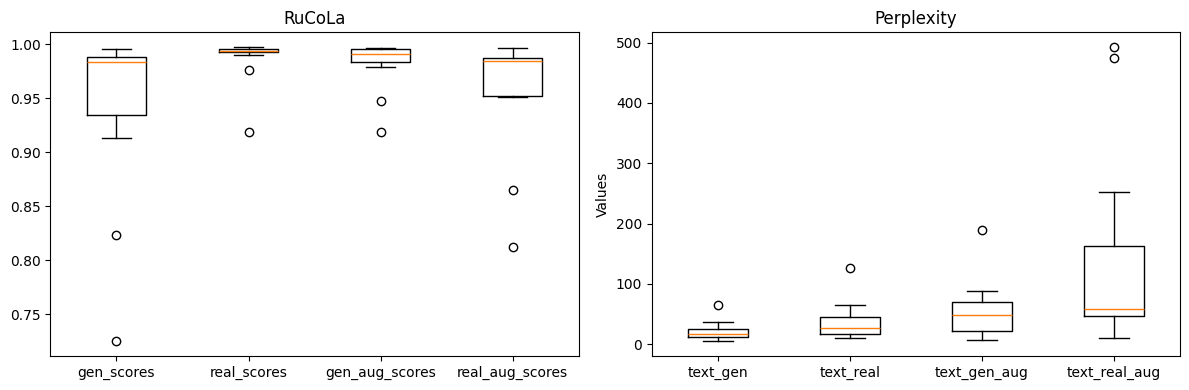

In [47]:
import matplotlib.pyplot as plt


# Male subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Dict
data_r = {
    "gen_scores": gen_scores,
    "real_scores": real_scores,
    "gen_aug_scores": gen_aug_scores,
    "real_aug_scores": real_aug_scores,
}
data_p = {
    "text_gen": perplex_text_gen,
    "text_real": perplex_text_real,
    "text_gen_aug": perplex_text_gen_aug,
    "text_real_aug": perplex_text_real_aug,
}

axes[0].boxplot(data_r.values())
axes[0].set_xticklabels(data_r.keys())
axes[0].set_title("RuCoLa")


axes[1].boxplot(data_p.values())
axes[1].set_xticklabels(data_p.keys())
axes[1].set_title("Perplexity")

plt.ylabel("Values")

plt.tight_layout()
plt.show()

Можно ли делать вывод о качестве текстов (и, соответственно, моделей, которые их генерируют)?

**Вывод:**

Мало того, что у сгенерированного текста метрики лучше, чем у человеческого. Так порченный текст показывает метрики лучше, чем исходный.

Нельзя полагаться только на цифры метрик. Необходимы дополнительные проверки работы нейросетевых решений, в т.ч. живыми людьми, особенно в задачах NLP.

## Формат результата

"Ящики с усами" метрик.

# Задание 2. Классификация с помощью BERT

Поработаем с данными эмоциональных окрасок отзывов [emotions dataset 🛠️[doc]](https://huggingface.co/datasets/emotion). Решим задачу классификации двумя способами:
* через эмбеддинги BERT-модели и ML-классификатор
* дообучая BERT в виде классификатора

**Задачи**:

1. Получите эмбеддинги каждого отзыва из кодировщика BERT.
2. Классифицируйте тексты с помощью методов ML, используя эмбеддинги в качестве входов.

3. Произведите fine-tuning кодировщика для задачи классификации и сравните, как изменилось качество классификации.

Импорт необходимых библиотек:

In [4]:
import torch
import evaluate
import numpy as np
import pandas as pd
from datasets import Dataset
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

Взглянем на датасет.

In [5]:
train = load_dataset("SetFit/emotion", split="train")
clear_output()

train_df = pd.DataFrame({"text": train["text"], "labels": train["label"]})
train_df.head()

,text,labels
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Текст токенизируется, токены передаются в BERT, BERT создаёт эмбеддинги. Они и будут данными для ML-классификатора.

**Учитывайте**, что:
* ML-модели работают с данными фиксированного размера.
* Длина эмбеддинга больше 200 в данной задаче не потребуется.
* Библиотеки в первой и второй части задания могут конфликтовать. Используйте "перезапуск сеанса", если так случилось.

Возьмите модель `bert-tiny` и соответствующий токенизатор.

In [6]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny2").to(device)
clear_output()
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(83828, 312, padding_idx=0)
    (position_embeddings): Embedding(2048, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)

Посмотрим на баланс классов:

In [54]:
label_counts = train_df['labels'].value_counts()
print(label_counts)

labels
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64


Оставим 5000 объектов, поделив их на обучение, валидацию, тест.

Будем семплировать, в функцию `sample` из `pandas` подадим веса для каждого объекта. Создадим столбец, в каждой строке которого будет частота семплирования.

In [55]:
train_df["freq"] = len(train_df) / train_df.groupby("labels")["labels"].transform(
    "count"
)
sampledf = train_df.sample(weights=train_df.freq)

In [56]:
sampledf = train_df.sample(5000, weights=train_df.freq)
sampledf["labels"].value_counts()

,count
labels,
1,994
0,973
4,886
3,875
2,771
5,501


Также имеет смысл проверить, что в колонке `labels` данные типа `int`. Если нет, то привести к этому типу.

In [57]:
sampledf["labels"] = sampledf["labels"].astype(int)

sample = list(sampledf["text"])
labels = list(sampledf["labels"])

Разделите данные на `train`, `val`, `test`. Получите `x_train`, `y_train` и т.д.

In [58]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(
    sampledf["text"], sampledf["labels"], test_size=0.4, stratify=sampledf["labels"], random_state=42
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

Посмотрите, как распределены метки в получившихся подвыборках.

In [59]:
print("Train:", pd.Series(y_train).value_counts())
print("Validation:", pd.Series(y_val).value_counts())
print("Test:", pd.Series(y_test).value_counts())

Train: labels
1    596
0    584
4    532
3    525
2    463
5    300
Name: count, dtype: int64
Validation: labels
1    199
0    194
4    177
3    175
2    154
5    101
Name: count, dtype: int64
Test: labels
1    199
0    195
4    177
3    175
2    154
5    100
Name: count, dtype: int64


Получите и сохраните векторные представления текстов, которые возвращает модель. Например, вот так. В `x_train` сейчас находится текст в виде букв.

In [60]:
train_emb = []
for t in x_train:
    encoded = tokenizer.encode(t, return_tensors="pt").to(device)
    output = model(encoded)["pooler_output"][0].detach().cpu()
    train_emb.append(output)

In [62]:
val_emb = []
for t in x_val:
    encoded = tokenizer.encode(t, return_tensors="pt").to(device)
    output = model(encoded)["pooler_output"][0].detach().cpu()
    val_emb.append(output)

In [61]:
test_emb = []
for t in x_test:
    encoded = tokenizer.encode(t, return_tensors="pt").to(device)
    output = model(encoded)["pooler_output"][0].detach().cpu()
    test_emb.append(output)

Возьмите ML-классификатор, например `RandomForest`, и обучите его.

In [63]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train_emb, y_train)

RandomForestClassifier()

Выведите `classification_report`.

In [64]:
from sklearn.metrics import classification_report

y_pred = clf.predict(test_emb)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.42      0.36       195
           1       0.37      0.61      0.46       199
           2       0.34      0.23      0.27       154
           3       0.33      0.28      0.30       175
           4       0.32      0.28      0.30       177
           5       0.55      0.06      0.11       100

    accuracy                           0.34      1000
   macro avg       0.37      0.31      0.30      1000
weighted avg       0.36      0.34      0.32      1000



Здесь не требуется получить 100% Presicion и Recall, достаточно получить более 0.3 `macro avg F1-score`.

**Попробуйте дообучить BERT и произвести классификацию заново.**

Загрузим данные заново. В этом разделе необходимо создать `Dataset` в формате `HuggingFace`.

In [65]:
train = load_dataset("SetFit/emotion", split="train")
clear_output()

train_df = pd.DataFrame({"text": train["text"], "labels": train["label"]})
train_df.head()
train_df["freq"] = len(train_df) / train_df.groupby("labels")["labels"].transform(
    "count"
)
sampledf = train_df.sample(weights=train_df.freq)
sampledf = train_df.sample(5000, weights=train_df.freq)
sampledf["labels"] = sampledf["labels"].astype(int)

sample = list(sampledf["text"])
labels = list(sampledf["labels"])
x_train, x_temp, y_train, y_temp = train_test_split(
    sampledf["text"], sampledf["labels"], test_size=0.4, stratify=sampledf["labels"], random_state=42
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

Заново разделите данные на `train`, `val`, `test`, как делали выше. Мы вновь начинаем с текстов в привычном буквенном формате.

In [66]:
from datasets import Dataset
from datasets.dataset_dict import DatasetDict

d = {
    "train": Dataset.from_dict({"label": y_train, "text": x_train}),
    "val": Dataset.from_dict({"label": y_val, "text": x_val}),
    "test": Dataset.from_dict({"label": y_test, "text": x_test}),
}

dataset = DatasetDict(d)

In [67]:
import evaluate

metric = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(
        predictions=predictions, references=labels, average="weighted"
    )

In [68]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 3000
    })
    val: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

Настройте токенизатор (если это не было сделано выше) так, чтобы производились дополнение (padding) и обрезка предложений. Имеет смысл указать длину получаемых векторных представлений (`model_max_length`).

In [69]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2", model_max_length=128)

Напишите функцию, которая будет токенизировать ваш текст в `DatasetDict`.

In [70]:
def preprocess_function(examples):
   return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

Токенизируйте ваши данные:

In [74]:
tokenized_data = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Посмотрите, как  выглядит ваш `DatasetDict`.

In [75]:
print(tokenized_data["train"][0])

{'label': 0, 'text': 'i feel so emotional when i saw those touch flusher but the position is still on the back when youre in seated position', 'input_ids': [2, 76, 12235, 773, 18446, 1085, 76, 4424, 2208, 17082, 18127, 11906, 590, 843, 531, 2362, 550, 2195, 561, 531, 1837, 1085, 5923, 538, 532, 4698, 737, 2362, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Проверьте размеры (`shape`) сущностей, которые он содержит.

In [76]:
print(tokenized_data['train'].shape)
print(tokenized_data['val'].shape)
print(tokenized_data['test'].shape)

(3000, 5)
(1000, 5)
(1000, 5)


Выведите первый объект из `train`.

Там должен находиться как исходный текст, так и его представление в виде токенов (из токенизатора, не из модели).

In [77]:
tokenized_data['train'][0]

{'label': 0,
 'text': 'i feel so emotional when i saw those touch flusher but the position is still on the back when youre in seated position',
 'input_ids': [2,
  76,
  12235,
  773,
  18446,
  1085,
  76,
  4424,
  2208,
  17082,
  18127,
  11906,
  590,
  843,
  531,
  2362,
  550,
  2195,
  561,
  531,
  1837,
  1085,
  5923,
  538,
  532,
  4698,
  737,
  2362,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

Импортируйте модель с учётом того, что вы уже решаете не просто задачу построения эмбеддингов, а задачу классификации. Укажите верное число классов в ней.

In [79]:
num_labels = len(train_df['labels'].unique())

In [88]:
model_for_classification = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2", num_labels=num_labels).to(device)

for param in model_for_classification.parameters():
    param.data = param.data.contiguous()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Задайте параметры, обучите модель:

In [89]:
from transformers import Trainer, TrainingArguments

# Your code here
training_args = TrainingArguments(
    output_dir="./my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs= 10,#about 1.5 minutes for 1 epoch
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy= "epoch",
    load_best_model_at_end= True,
    push_to_hub=False,
    report_to="none",
)



trainer = Trainer(
    model=model_for_classification,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=tokenized_data['train'],         # training dataset
    eval_dataset=tokenized_data['val'],
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,1.575345,0.351981
2,1.678800,1.214723,0.617494
3,1.234300,0.985286,0.709824
4,0.899800,0.813319,0.763774
5,0.899800,0.688956,0.784648
6,0.651300,0.611340,0.805156
7,0.484100,0.568983,0.815807
8,0.408200,0.560851,0.825924
9,0.408200,0.537056,0.829263
10,0.352400,0.531431,0.825454


TrainOutput(global_step=3750, training_loss=0.783621201578776, metrics={'train_runtime': 112.8288, 'train_samples_per_second': 265.89, 'train_steps_per_second': 33.236, 'total_flos': 55335398400000.0, 'train_loss': 0.783621201578776, 'epoch': 10.0})

Мы дообучили модель! Теперь проверим качество предсказания на тесте.

Можете использовать `trainer.predict`.

In [90]:
predictions = trainer.predict(tokenized_data["test"])
predicted_labels = np.argmax(predictions.predictions, axis=-1)

In [91]:
from sklearn.metrics import classification_report


print(classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83       193
           1       0.85      0.72      0.78       197
           2       0.80      0.85      0.83       155
           3       0.88      0.85      0.87       181
           4       0.82      0.81      0.81       173
           5       0.80      0.93      0.86       101

    accuracy                           0.83      1000
   macro avg       0.83      0.84      0.83      1000
weighted avg       0.83      0.83      0.83      1000



Получите не менее 80% `marco avg F1-score` на тесте.

Если у вас получилось ровно 100%, проверьте, что и с чем вы сравниваете. По умолчанию `predict` возвращает логиты и истинные метки, которые были изначально в переданном объекте.

## Формат результата

Получить значение качества классификации.

# Задание 3. Генерация текста

Возьмите произведение Гете "Фауст" (или любой свой текст) и дообучите на нем модель генерации текста.

Во время обучения игнорируйте знаки препинания и номера страниц.

Используйте предобученную модель `sberbank-ai/rugpt3small_based_on_gpt2` из библиотеки Hugging Face. Попробуйте разные параметры модели (например, разные режимы генерации). Как меняется результат?


Импорт необходимых библиотек:

In [7]:
import torch
from transformers import Trainer, TrainingArguments
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import TextDataset, DataCollatorForLanguageModeling
from IPython.display import clear_output

## Загрузка и подготовка данных

In [8]:
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Faust.txt

In [9]:
with open("Faust.txt") as text_file:
    faust_text = "".join(text_file.readlines())

In [10]:
faust_text

'вы вновь со мной, туманные виденья,\nмне в юности мелькнувшие давно…\nвас удержу ль во власти вдохновенья?\nбылым ли снам явиться вновь дано?\nиз сумрака, из тьмы полузабвенья\nвосстали вы… о, будь, что суждено!\nкак в юности, ваш вид мне грудь волнует,\nи дух мой снова чары ваши чует.\nвы принесли с собой воспоминанье\nвеселых дней и милых теней рой;\nвоскресло вновь забытое сказанье\nлюбви и дружбы первой предо мной;\nвсе вспомнилось: и прежнее страданье,\nи жизни бег запутанной чредой,\nи образы друзей, из жизни юной\nисторгнутых, обманутых фортуной.\nкому я пел когда-то, вдохновенный,\nтем песнь моя – увы! – уж не слышна…\nкружок друзей рассеян по вселенной,\nих отклик смолк, прошли те времена.\nя чужд толпе со скорбью, мне священной,\nмне самая хвала ее страшна,\nа те, кому моя звучала лира,\nкто жив еще, – рассеяны средь мира.\nи вот воскресло давнее стремленье\nтуда, в мир духов, строгий и немой,\nи робкое родится песнопенье,\nстеня, дрожа эоловой струной;\nв суровом сердце тре

In [11]:
len(faust_text.split(" "))

51923

## Предобученная sberbank-ai GPT2

Возьмите предобученную модель и попробуйте сгенерировать текст с ее помощью. Оцените результаты.

Весь текст подать на вход не получится. Подайте первые 30 слов.

In [113]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel


model_name_or_path = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path)

text = faust_text.split(" ")[:30]
input_ids = tokenizer.encode(text, return_tensors="pt")

sample_output = model.generate(
    input_ids,
    do_sample=True,
    max_length=100,
)

generated_text = tokenizer.decode(sample_output[0], skip_special_tokens=True)
clear_output()

In [114]:
print(generated_text)

 котором мы все собрались, но тем не менее.



О том, как в том далеком прошлом люди, которые на протяжении многих поколений сохраняли и развивали эти традиции, жили у истоков этих традиций были неписаные нормы поведения


Слово «реликвия» переводится с древнегреского языка как «волшебный»,


## Файнтюнинг sberbank-ai GPT2

Дообучите модель. Для этого сначала создадим датасет и `data_collator`, который нарезает текст на оптимальные по длине кусочки:

In [115]:
from transformers import TextDataset, DataCollatorForLanguageModeling


train_path = "Faust.txt"

train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path, block_size=64)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
clear_output()

In [119]:
from transformers import Trainer, TrainingArguments
from torch.optim import AdamW
from transformers import get_scheduler
import math

model.to(device)

# Your code here
training_args = TrainingArguments(
    output_dir='./faust_model', #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=10, # number of training epochs
    per_device_train_batch_size=8, # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    warmup_steps=50,# number of warmup steps for learning rate scheduler
    gradient_accumulation_steps=2, # to make "virtual" batch size larger
    report_to="none",
)

optimizer = AdamW(model.parameters(), lr=5e-5)


num_update_steps_per_epoch = math.ceil(len(train_dataset) / training_args.per_device_train_batch_size)
max_train_steps = training_args.num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=max_train_steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers = (optimizer, lr_scheduler) # Your code here # Optimizer and lr scheduler
)

In [120]:
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,3.558300
1000,2.437700


TrainOutput(global_step=1110, training_loss=2.8923602129961994, metrics={'train_runtime': 366.8875, 'train_samples_per_second': 48.271, 'train_steps_per_second': 3.025, 'total_flos': 578435235840000.0, 'train_loss': 2.8923602129961994, 'epoch': 10.0})

In [121]:
# Probability beam sampling example
text = "Ходил"
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True,
        num_beams=2,
        temperature=1.5,
        top_p=0.9,
        max_length=200,
    )

generated_text = list(map(tokenizer.decode, out))[0]

In [122]:
print(generated_text)

Ходил по горам он,
везде искал приключений;
теперь же повсюду
он верхом на коне
и по горам скакать будет.
зато он знает, где искать,
и верный путь себе найдет.
пусть вьется он везде,
где только можно,
и в каждой щели найдет лаз.
пусть вьется он везде, свободный,
и в каждой щели найдет!
но все-таки в глубине души
ему страшно: что-то там мелькает
и тревожит его, точно там
что-то было. вот он вскочил на козла
и помчится галопом по горам!
назад же, свезет он меня с собой!
зачем, зачем, скажи мне, подвез я тебя?
дрянная весть! вот досада!
возьми-ка меня с собою! мне надоело быть козлом!
мне надоело быть козлом! отвези меня
туда,


## Другая модель с HuggingFace

In [12]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel


tokenizer = GPT2Tokenizer.from_pretrained(
    "ai-forever/rugpt3small_based_on_gpt2", clean_up_tokenization_spaces=False
)
model = GPT2LMHeadModel.from_pretrained("ai-forever/rugpt3small_based_on_gpt2")

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [13]:
from transformers import TextDataset, DataCollatorForLanguageModeling

train_path = "Faust.txt"

train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path, block_size=64)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
clear_output()

In [16]:
from transformers import Trainer, TrainingArguments
from torch.optim import AdamW
from transformers import get_scheduler
import math

model.to(device)

training_args = TrainingArguments(
    output_dir='./faust_model', #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=10, # number of training epochs
    per_device_train_batch_size=8, # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    warmup_steps=50,# number of warmup steps for learning rate scheduler
    gradient_accumulation_steps=2, # to make "virtual" batch size larger
    report_to="none",
)

optimizer = AdamW(model.parameters(), lr=5e-5)


num_update_steps_per_epoch = math.ceil(len(train_dataset) / training_args.per_device_train_batch_size)
max_train_steps = training_args.num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=max_train_steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers = (optimizer, lr_scheduler) # Your code here # Optimizer and lr scheduler
)

In [17]:
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,3.558300
1000,2.437700


TrainOutput(global_step=1110, training_loss=2.8923602129961994, metrics={'train_runtime': 416.8616, 'train_samples_per_second': 42.484, 'train_steps_per_second': 2.663, 'total_flos': 578435235840000.0, 'train_loss': 2.8923602129961994, 'epoch': 10.0})

In [18]:
# Probability beam sampling example
text = "все"
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
model.eval()
with torch.no_grad():
    out = model.generate(
        input_ids,
        do_sample=True,
        num_beams=1,
        temperature=1.6,
        top_p=0.7,
        max_length=100,
        pad_token_id=tokenizer.eos_token_id,
    )

generated_text = list(map(tokenizer.decode, out))[0]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [19]:
print(generated_text)

все ж, надеюсь, к чести хозяйки,
впервые к столу я сел напротив нее.
не спится тебе? вот уж кубок принес
тебя и твой я принес. что сталось с тем
феболом ты закален? с тех пор
средь мрака скрытого забвенья
счастью лишь чернь вечно предана;
туман вокруг комнаты вмиг потускнел;
как тени предков, сюда теперь
не обращусь я благосклонно.



## Формат результата

Сгенерированный текст

Пример текста:

"все все от бесстыдные старой

все в нем получше все стремленья

поддержки с собой в сердце воздух своей

и в вечной страсти восстанет свой предлог

привет вам слуга в сладком страшней стране

и в мире все вражда станет станет

в поле на пользу своим воспоминанья"


# Задание 4. QLoRa

***Перед выполнением задания может потребоваться перезагрузить среду и выполнить вспомогательный код.***

Дообучите большую языковую модель.

В этом задании мы предлагаем для проверки подхода взять готовый датасет, загрузка которого реализована ниже.

Идея задания состоит в том, чтобы вы прошли весь путь по запуску дообучения по методу LoRa. Здесь не требуется брать большие модели или учить сотни эпох.

В задании используется `SFTTrainer` [🛠️[doc]](https://huggingface.co/docs/trl/sft_trainer) (Supervised Fine Tune Trainer).

Это обёртка над классом `Trainer` для обучения моделей на наборах инструкций с использованием адаптеров PEFT.

Установка и импорт необходимых библиотек:

In [20]:
!pip install -q zstandard jsonlines

In [21]:
import torch
import bitsandbytes as bnb
from trl import SFTTrainer
from peft import LoraConfig
from datasets import load_dataset
from transformers import AutoTokenizer, TrainingArguments
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from IPython.display import clear_output

## Загрузка и подготовка данных

Для отладки воспользуемся небольшой моделью из предыдущего задания. После этого можете воспользоваться уже серьёзной моделью, например `"RefalMachine/RuadaptQwen2.5-1.5B-instruct"`, и попробовать улучшить её результат (который даже "из коробки" будет гораздо качественее).

In [22]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

model_name = "ai-forever/rugpt3small_based_on_gpt2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
)
model.gradient_checkpointing_enable()  # Saves GPU memory
model.config.use_cache = False

clear_output()

Загрузите токенизатор. Вам может помочь параметр `trust_remote_code=True`.

In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Загрузите датасет:

In [24]:
from datasets import load_dataset

dataset_name = "IlyaGusev/ru_turbo_alpaca"
dataset = load_dataset(dataset_name, split="train", trust_remote_code=True)

README.md:   0%|          | 0.00/3.31k [00:00<?, ?B/s]

ru_turbo_alpaca.py:   0%|          | 0.00/2.57k [00:00<?, ?B/s]

ru_turbo_alpaca.jsonl.zst:   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/29822 [00:00<?, ? examples/s]

Датасет представляет собой набор простых вопросов и ответов.

In [25]:
dataset

Dataset({
    features: ['instruction', 'input', 'output', 'alternative_output', 'label', 'all_labels', 'agreement', 'overlap'],
    num_rows: 29822
})

Проверьте, насколько качественно модель умеет работать. Задайте вопрос из только что загруженного датасета.

In [36]:
example = dataset[0]
instruction = example['instruction']
input_text = example['input']
reference_output = example['output']

prompt =  f"Вопрос: {instruction}\nОтвет:"

inputs = tokenizer(prompt, return_tensors="pt").to("cuda")


with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=True,
        top_p=0.95,
        temperature=0.7,
        eos_token_id=tokenizer.eos_token_id
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

In [37]:
generated_text

'Вопрос: Опишите, как сделать горшок из глины.\nОтвет: Для начала нужно купить и купить горшок с глиной. Но даже если вы не знаете, как сделать горшок из глины, то это не сложно. Но лучше всего использовать пластик. Но если у вас нет такого материала, то можно сделать просто горшок из глины. В принципе, это не сложно, но лучше всего использовать пластик. Но если у вас нет такого материала, то можно сделать просто горшок из глины. В принципе, это не сложно, но лучше всего использовать пластик. Но если у вас'

**Дообучение модели**

Необходимо в одну инструкцию заложить и вопрос, и ответ. Преобразуйте датасет так, чтобы можно было подать единственное текстовое поле далее в `SFTrainer`.

In [38]:
def preprocess_data(example):
    example["text"] = f"Вопрос: {example['instruction']}\nОтвет: {example['output']}"
    return example

dataset = dataset.map(preprocess_data)

Map:   0%|          | 0/29822 [00:00<?, ? examples/s]

Воспользуйтесь библиотекой peft и настройте `peft_config`, определите `target_modules` для LoRa:

In [39]:
lora_alpha = 64
lora_dropout = 0.1
lora_r = 16

In [40]:
def find_all_linear_names(model):
    """
    Find modules to apply LoRA to.

    :param model: PEFT model
    """

    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    print(f"LoRA module names: {list(lora_module_names)}")
    return list(lora_module_names)
target_modules=find_all_linear_names(model)

LoRA module names: ['c_proj', 'c_attn', 'c_fc']


In [41]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    target_modules =target_modules,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

Настройте параметры и передайте их в `TrainingArguments`:

In [54]:
from transformers import TrainingArguments

output_dir = "./lora_train_results"
per_device_train_batch_size = 8
gradient_accumulation_steps = 8
optim = "paged_adamw_32bit"
save_steps = 100
logging_steps = 50
learning_rate = 2e-5
max_grad_norm = 2
max_steps = -1
warmup_ratio = 0.1
lr_scheduler_type = "linear"
num_train_epochs=3

training_arguments = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    num_train_epochs=num_train_epochs,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    report_to="none",
    gradient_checkpointing=True,
)

Подайте всё в `SFTTrainer`:

In [55]:
from trl import SFTTrainer


trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,  # your dataset
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments,
)

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:168: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [56]:
trainer.train()

Step,Training Loss
50,3.288500
100,3.055200
150,2.863700
200,2.730500
250,2.601300
300,2.530800
350,2.505500
400,2.446700
450,2.436700
500,2.350500


TrainOutput(global_step=1398, training_loss=2.4572664460058036, metrics={'train_runtime': 1694.6795, 'train_samples_per_second': 52.792, 'train_steps_per_second': 0.825, 'total_flos': 3796057482043392.0, 'train_loss': 2.4572664460058036})

Изменилось ли качество генерации после обучения?
Попробуйте вновь подать тот же промпт. Модель должна выдать ответ, более похожий на уже виденный каноничный ответ.

In [60]:
prompt = "Вопрос:Опишите, как сделать горшок из глины?\nОтвет:"

inputs = tokenizer(prompt, return_tensors="pt").to(device)
output = model.generate(inputs['input_ids'], max_length=256,
                        num_return_sequences=1,
                        )

generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Вопрос:Опишите, как сделать горшок из глины?
Ответ: Для того, чтобы сделать горшок из глины, необходимо использовать глину, которая имеет высокую температуру и имеет высокую прочность. Для того, чтобы сделать горшок из глины, необходимо использовать глину, которая имеет высокую температуру и имеет высокую прочность. Для того, чтобы сделать горшок из глины, необходимо использовать глину, которая имеет высокую температуру и имеет высокую прочность. Для того, чтобы сделать горшок из глины, необходимо использовать глину, которая имеет высокую температуру и имеет высокую прочность. Для того, чтобы сделать горшок из глины, необходимо использовать глину, которая имеет высокую температуру и имеет высокую прочность. Для того, чтобы сделать горшок из глины, необходимо использовать глину, которая имеет высокую температуру и имеет высокую прочность. Для того, чтобы сделать горшок из глины, необходимо использовать глину, которая имеет высокую температуру и имеет высокую прочность. Для того, чтобы с

Если есть желание, можно воспользоваться специальным поисковиком по NLP-моделям и найти [модель побольше🛠️[doc]](https://llm.extractum.io/model/Defetya%2Fopenllama-3b-saiga,5NvQyABIZu8ZZa2NCI6BQN), которая всё ещё влезает в коллаб. Но ресурсов коллаба всё равно не хватит для обучения, тут нужна Датасфера или что-то подобное.

## Формат результата

Сгенерированный текст ответа на поданный вопрос. Пример:


```
Опишите, как сделать горшок из глины.

Горшок из глины
Глина (2 столовые ложки)

Инструкции:

1. Размешайте глину в ведре до однородности.

2. Вам понадобится деревянная палочка для насыпки глины.

3. Выложите горшок в целлофан и привяжите его к стенке горшка для дополнительной устойчивости.

4. Наполните горшок поочередно смесью, начиная отверхности.

5. Разложите насыпку из глины по стенкам горшка.

6. Возьмите лопату, кисточку и палочку, чтобы создать каркас горшка.

7. Украсьте горшок из глины различными текстурами и цветами, такими как камень, металл, стекло и другие материалы.

Посмотрите видео, чтобы узнать больше о том, как сделать горшок из глины:

Приятного творчества!
```